# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [2]:
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

A Jupyter Widget

In [3]:
img_shape

(38, 38, 3)

In [4]:
attr[:2]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,-0.602662,-0.83636,0.909554,-2.03901,-0.937008,-0.520853,-0.399348,-0.609662,-0.328941,-1.20055,...,-0.793891,-1.77256,0.234426,-0.531727,-2.35169,0.0929558,1.51383,-0.176601,-0.335991,-0.882286
1,0.505597,-1.91405,2.51025,-2.4314,-1.00337,-1.44539,-1.537,-0.204474,0.487091,-1.74747,...,0.0096608,-0.374216,-0.0136298,-0.0809645,-2.12532,0.281169,-1.24167,-0.515579,0.1815,-0.80375


X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


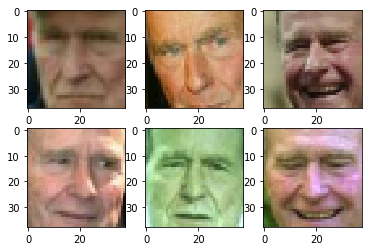

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [3]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

Using TensorFlow backend.


## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [10]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [11]:
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [12]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - ETA: 514s - loss: 0.297 - ETA: 87s - loss: 0.324 - ETA: 53s - loss: 0.27 - ETA: 36s - loss: 0.20 - ETA: 26s - loss: 0.15 - ETA: 21s - loss: 0.12 - ETA: 18s - loss: 0.11 - ETA: 16s - loss: 0.10 - ETA: 14s - loss: 0.09 - ETA: 12s - loss: 0.08 - ETA: 11s - loss: 0.07 - ETA: 10s - loss: 0.07 - ETA: 9s - loss: 0.0661 - ETA: 8s - loss: 0.062 - ETA: 8s - loss: 0.059 - ETA: 7s - loss: 0.056 - ETA: 7s - loss: 0.054 - ETA: 6s - loss: 0.052 - ETA: 6s - loss: 0.051 - ETA: 6s - loss: 0.049 - ETA: 5s - loss: 0.048 - ETA: 5s - loss: 0.047 - ETA: 5s - loss: 0.046 - ETA: 4s - loss: 0.045 - ETA: 4s - loss: 0.044 - ETA: 4s - loss: 0.043 - ETA: 4s - loss: 0.042 - ETA: 4s - loss: 0.042 - ETA: 4s - loss: 0.041 - ETA: 3s - loss: 0.040 - ETA: 3s - loss: 0.039 - ETA: 3s - loss: 0.039 - ETA: 3s - loss: 0.038 - ETA: 3s - loss: 0.038 - ETA: 3s - loss: 0.037 - ETA: 2s - loss: 0.037 - ETA: 2s - loss: 0.036 - E

11828/11828 [==============================] - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.012 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0

11828/11828 [==============================] - ETA: 4s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

11828/11828 [==============================] - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 4s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0

In [28]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    #print(code.shape)
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))   # // is not necessary, Cos if not interger division, error throw

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


In [14]:
img = X_test[0]
code = encoder.predict(img[None])

In [15]:
code

array([[ -3.16764563e-02,  -6.40683711e-01,   8.77339065e-01,
         -1.32177025e-04,  -1.77972183e-01,  -1.87144190e-01,
          1.39534235e-01,   3.19349468e-01,   1.84848213e+00,
          1.63514927e-01,  -2.21869260e-01,  -8.30847919e-02,
          6.83987856e-01,   1.79139182e-01,  -3.96167874e-01,
          1.06841059e+01,  -7.83281803e-01,   8.53971615e-02,
         -4.93055582e-01,   3.53657365e-01,  -1.82693914e-01,
         -7.91967809e-02,  -1.13255596e+00,  -5.92728615e-01,
          5.16313374e-01,  -4.20379400e-01,   3.68225396e-01,
         -3.96009386e-01,   8.51777345e-02,   3.01918119e-01,
         -1.20387807e-01,   7.24401236e-01]], dtype=float32)

In [16]:
ax = np.array([1,2,3,4,5])
ax

array([1, 2, 3, 4, 5])

Final MSE: 0.00672859640742


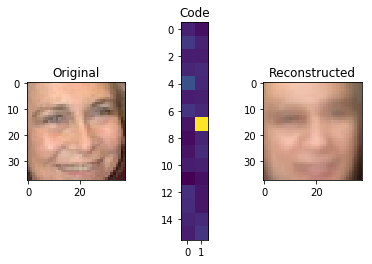

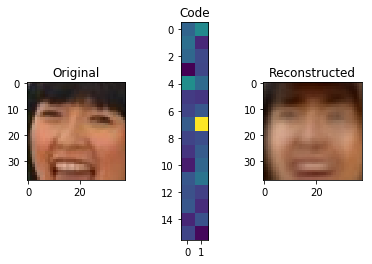

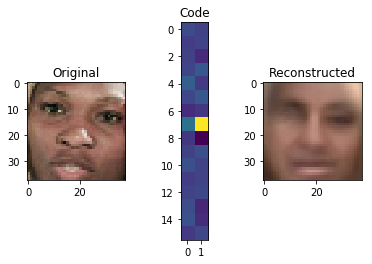

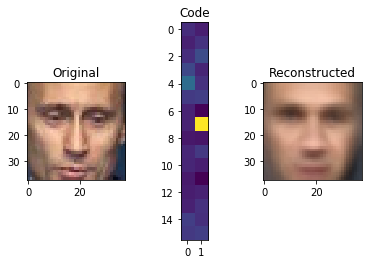

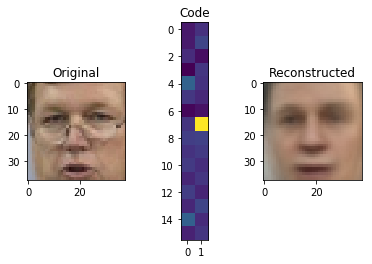

In [17]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [82]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2),  activation=None, padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=16, kernel_size=(5, 5), strides=(2, 2),  activation=None, padding='same'))
    encoder.add(L.BatchNormalization())
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),  activation=None, padding='valid'))  
    encoder.add(L.BatchNormalization())
    encoder.add(L.advanced_activations.LeakyReLU())
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    
    
    H_hat = 8
    W_hat = 8
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(H_hat * W_hat * 16))
    decoder.add(L.Reshape((H_hat, W_hat, 16)))
    decoder.add(L.Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(1, 1), padding= 'valid',activation=None))
    decoder.add(L.BatchNormalization())
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding= 'same',activation=None))
    decoder.add(L.BatchNormalization())
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding= 'same',activation=None))
    decoder.add(L.BatchNormalization())
    decoder.add(L.advanced_activations.LeakyReLU())
    decoder.add(L.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding= 'valid',activation=None))
    #decoder.add(L.advanced_activations.LeakyReLU())
                
    return encoder,decoder

In [83]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [92]:
adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)

In [93]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
#autoencoder.compile('adamax','mse')
autoencoder.compile(loss='mse', optimizer=adam)

Training may take some 20 minutes.

In [94]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_120 (InputLayer)       (None, 38, 38, 3)         0         
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 19, 19, 32)        2432      
_________________________________________________________________
batch_normalization_85 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
leaky_re_lu_284 (LeakyReLU)  (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 10, 10, 16)        12816     
_________________________________________________________________
batch_normalization_86 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
leaky_re_lu_285 (LeakyReLU)  (None, 10, 10, 16)        0         
__________

In [95]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       (None, 32)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 1024)              33792     
_________________________________________________________________
reshape_56 (Reshape)         (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_transpose_88 (Conv2DT (None, 10, 10, 16)        2320      
_________________________________________________________________
batch_normalization_88 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
leaky_re_lu_287 (LeakyReLU)  (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_transpose_89 (Conv2DT (None, 20, 20, 32)        12832     
__________

In [96]:
autoencoder.fit(x=X_train,y=X_train, epochs=100, batch_size=128,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/100
11828/11828 [==============================] - ETA: 8:59 - loss: 1.843 - ETA: 4:42 - loss: 1.543 - ETA: 3:17 - loss: 1.207 - ETA: 2:33 - loss: 0.970 - ETA: 2:07 - loss: 0.811 - ETA: 1:50 - loss: 0.707 - ETA: 1:37 - loss: 0.629 - ETA: 1:28 - loss: 0.567 - ETA: 1:20 - loss: 0.516 - ETA: 1:14 - loss: 0.474 - ETA: 1:09 - loss: 0.439 - ETA: 1:04 - loss: 0.409 - ETA: 1:01 - loss: 0.383 - ETA: 57s - loss: 0.361 - ETA: 54s - loss: 0.34 - ETA: 52s - loss: 0.32 - ETA: 50s - loss: 0.30 - ETA: 48s - loss: 0.29 - ETA: 46s - loss: 0.28 - ETA: 44s - loss: 0.27 - ETA: 42s - loss: 0.25 - ETA: 41s - loss: 0.24 - ETA: 40s - loss: 0.24 - ETA: 38s - loss: 0.23 - ETA: 37s - loss: 0.22 - ETA: 36s - loss: 0.21 - ETA: 35s - loss: 0.21 - ETA: 34s - loss: 0.20 - ETA: 33s - loss: 0.19 - ETA: 32s - loss: 0.19 - ETA: 31s - loss: 0.18 - ETA: 30s - loss: 0.18 - ETA: 29s - loss: 0.17 - ETA: 29s - loss: 0.17 - ETA: 28s - loss: 0.17 - ETA: 27s - loss: 0.16 - E

11828/11828 [==============================] - ETA: 29s - loss: 0.01 - ETA: 29s - loss: 0.01 - ETA: 29s - loss: 0.01 - ETA: 29s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 26s - loss: 0.01 - ETA: 26s - loss: 0.01 - ETA: 26s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 24s - loss: 0.01 - ETA: 24s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.01 - ETA: 30s - loss: 0.01 - ETA: 29s - loss: 0.01 - ETA: 29s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 28s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 27s - loss: 0.01 - ETA: 26s - loss: 0.01 - ETA: 26s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 25s - loss: 0.01 - ETA: 24s - loss: 0.01 - ETA: 24s - loss: 0.01 - ETA: 24s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 23s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 22s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 21s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 20s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 19s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 18s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 17s - loss: 0.01 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 27s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 

11828/11828 [==============================] - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 31s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 27s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 31s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 

11828/11828 [==============================] - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

11828/11828 [==============================] - ETA: 31s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 30s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 26s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 

In [97]:
autoencoder.save_weights("my_autoencoder.h5")

In [98]:
autoencoder.load_weights("my_autoencoder.h5")

In [99]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
print(reconstruction_mse)
# assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
# assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

0.00625692100048
Final MSE: 0.00625692100048


NameError: name 'plt' is not defined

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [42]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    #<your code here>
    noise = np.random.normal(0 , sigma, size = X.shape )    
    return X + noise
    

In [43]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

In [44]:
X.shape

(13143, 38, 38, 3)

In [45]:
X[:1].shape

(1, 38, 38, 3)

In [46]:
X[0].shape

(38, 38, 3)

In [47]:
apply_gaussian_noise(X[:1],sigma=0.01).shape

(1, 38, 38, 3)

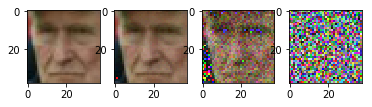

In [48]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[0],sigma=0.01))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [49]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [50]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

Epoch 0/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10816/11828 [==========================>...] - ETA: 279s - loss: 0.049 - ETA: 179s - loss: 0.046 - ETA: 145s - loss: 0.042 - ETA: 136s - loss: 0.039 - ETA: 129s - loss: 0.038 - ETA: 123s - loss: 0.038 - ETA: 119s - loss: 0.037 - ETA: 116s - loss: 0.036 - ETA: 113s - loss: 0.035 - ETA: 111s - loss: 0.035 - ETA: 110s - loss: 0.034 - ETA: 110s - loss: 0.034 - ETA: 108s - loss: 0.034 - ETA: 107s - loss: 0.033 - ETA: 105s - loss: 0.033 - ETA: 104s - loss: 0.033 - ETA: 104s - loss: 0.033 - ETA: 102s - loss: 0.032 - ETA: 101s - loss: 0.032 - ETA: 100s - loss: 0.032 - ETA: 99s - loss: 0.031 - ETA: 99s - loss: 0.03 - ETA: 99s - loss: 0.03 - ETA: 99s - loss: 0.03 - ETA: 99s - loss: 0.03 - ETA: 99s - loss: 0.03 - ETA: 99s - loss: 0.02 - ETA: 99s - loss: 0.02 - ETA: 99s - loss: 0.02 - ETA: 98s - loss: 0.02 - ETA: 98s - loss: 0.02 - ETA: 97s - loss: 0.02 - ETA: 97s - loss: 0.02 - ETA: 96s - loss: 0.02 - ETA: 96s - loss: 0.02 - ETA: 96s - loss: 0.02 - ETA: 95s - loss: 0.02 - ETA: 96s - loss: 0.02 - 

10688/11828 [==========================>...] - ETA: 104s - loss: 0.006 - ETA: 113s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 119s - loss: 0.006 - ETA: 121s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 121s - loss: 0.006 - ETA: 121s - loss: 0.006 - ETA: 121s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 121s - loss: 0.005 - ETA: 121s - loss: 0.005 - ETA: 122s - loss: 0.005 - ETA: 121s - loss: 0.006 - ETA: 121s - loss: 0.005 - ETA: 122s - loss: 0.005 - ETA: 122s - loss: 0.005 - ETA: 121s - loss: 0.005 - ETA: 121s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 120s - loss: 0.006 - ETA: 120s - loss: 0.005 - ETA: 120s - loss: 0.006 - ETA: 119s - loss: 0.005 - ETA: 119s - loss: 0.005 - ETA: 118s - loss: 0.005 - ETA: 118s - loss: 0.005 - ETA: 118s - loss: 0.005 - ETA: 118s - loss: 0.005 - ETA: 117s - loss: 0.005 - ETA: 117s - loss: 0.005 - ETA: 117s - loss: 0.005 - ETA: 116s - loss: 0.005 - ETA: 116s - loss: 0.005 - ETA: 116s - loss:

11828/11828 [==============================] - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 9s - loss: 0.005 - ETA: 8s - loss: 0.005 - ETA: 8s - loss: 0.005 - ETA: 8s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 7s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 105s - loss: 0.0051 - val_loss: 0.0045
Epoch 2/50, Generating corrupted samples...
Train on 11828 samples, valida

10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 75s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 

10880/11828 [==========================>...] - ETA: 78s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.003 - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 98s - loss: 0.0036 - val_loss: 0.0034
Epoch 4/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 76s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 101s - loss: 0.003 - ETA: 103s - loss: 0.003 - ETA: 103s - loss: 0.003 - ETA: 102s - loss: 0.003 - ETA: 100s - loss: 0.003 - ETA: 99s - loss: 0.003 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 8

10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 75s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 96s - loss: 0.0031 - val_loss: 0.0030
Epoch 6/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 

10880/11828 [==========================>...] - ETA: 76s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 100s - loss: 0.0028 - val_loss: 0.0027
Epoch 8/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 77s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 

10880/11828 [==========================>...] - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 100s - loss: 0.0025 - val_loss: 0.0027
Epoch 10/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 79s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 

10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 100s - loss: 0.0024 - val_loss: 0.0024
Epoch 12/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 83s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 

10880/11828 [==========================>...] - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 

11828/11828 [==============================] - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 110s - loss: 0.0023 - val_loss: 0.0023
Epoch 14/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 

10880/11828 [==========================>...] - ETA: 76s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 104s - loss: 0.0022 - val_loss: 0.0023
Epoch 16/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10784/11828 [==========================>...] - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 113s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 107s - loss: 0.002 - ETA: 106s - loss: 0.002 - ETA: 105s - loss: 0.002 - ETA: 104s - loss: 0.002 - ETA: 104s - loss: 0.002 - ETA: 103s - loss: 0.002 - ETA: 103s - loss: 0.002 - ETA: 104s - loss: 0.002 - ETA: 104s - loss: 0.002 - ETA: 103s - loss: 0.002 - ETA: 103s - loss: 0.002 - ETA: 102s - loss: 0.002 - ETA: 101s - loss: 0.002 - ETA: 101s - loss: 0.002 - ETA: 101s - loss: 0.002 - ETA: 101s - loss: 0.002 - ETA: 100s - loss: 0.002 - ETA: 100s - loss: 0.002 - ETA: 99s - loss: 0.002 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.0

10880/11828 [==========================>...] - ETA: 80s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 102s - loss: 0.0021 - val_loss: 0.0022
Epoch 18/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 

10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 98s - loss: 0.0020 - val_loss: 0.0021
Epoch 20/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 80s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 

10720/11828 [==========================>...] - ETA: 104s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.002 - ETA: 107s - loss: 0.002 - ETA: 107s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 112s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 111s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 110s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 109s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 108s - loss: 0.002 - ETA: 107s - loss: 0.002 - ETA: 106s - loss:

11828/11828 [==============================] - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0020 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 8s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 7s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 115s - loss: 0.0020 - val_loss: 0.0021
Epoch 22/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epo

10880/11828 [==========================>...] - ETA: 87s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 

10816/11828 [==========================>...] - ETA: 91s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ET

11828/11828 [==============================] - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 108s - loss: 0.0019 - val_loss: 0.0020
Epoch 24/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10784/11828 [==========================>...] - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.0

10816/11828 [==========================>...] - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 

11828/11828 [==============================] - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 110s - loss: 0.0019 - val_loss: 0.0020
Epoch 26/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - E

10880/11828 [==========================>...] - ETA: 91s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - los

11828/11828 [==============================] - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 111s - loss: 0.0018 - val_loss: 0.0020
Epoch 28/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10784/11828 [==========================>...] - ETA: 103s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA:

10784/11828 [==========================>...] - ETA: 96s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001

11828/11828 [==============================] - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 111s - loss: 0.0018 - val_loss: 0.0019
Epoch 30/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 88s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 9

10784/11828 [==========================>...] - ETA: 92s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 103s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA:

11828/11828 [==============================] - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 109s - loss: 0.0018 - val_loss: 0.0019
Epoch 32/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 92s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ET

10752/11828 [==========================>...] - ETA: 95s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 101s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.0

11828/11828 [==============================] - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 111s - loss: 0.0017 - val_loss: 0.0019
Epoch 34/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 

10784/11828 [==========================>...] - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.0

11828/11828 [==============================] - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 113s - loss: 0.0017 - val_loss: 0.0019
Epoch 36/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10784/11828 [==========================>...] - ETA: 124s - loss: 0.001 - ETA: 123s - loss: 0.001 - ETA: 120s - loss: 0.001 - ETA: 116s - loss: 0.001 - ETA: 114s - loss: 0.001 - ETA: 113s - loss: 0.001 - ETA: 111s - loss: 0.001 - ETA: 111s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 111s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 110s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 109s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 108s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 107s - loss: 0.001 - ETA: 106s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 105s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss:

10880/11828 [==========================>...] - ETA: 84s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 105s - loss: 0.0017 - val_loss: 0.0019
Epoch 38/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 82s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 104s - loss: 0.001 - ETA: 104s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 103s - loss: 0.001 - ETA: 102s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 101s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 96s -

10880/11828 [==========================>...] - ETA: 84s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 88s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 97s - loss: 0.0017 - val_loss: 0.0018
Epoch 40/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 76s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 

10880/11828 [==========================>...] - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 95s - loss: 0.0017 - val_loss: 0.0018
Epoch 42/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 75s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 

10880/11828 [==========================>...] - ETA: 78s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 94s - loss: 0.0016 - val_loss: 0.0018
Epoch 44/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 75s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 

10880/11828 [==========================>...] - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 77s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 77s - loss: 

11828/11828 [==============================] - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 92s - loss: 0.0016 - val_loss: 0.0018
Epoch 46/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10848/11828 [==========================>...] - ETA: 93s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 100s - loss: 0.001 - ETA: 99s - loss: 0.001 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 99s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 98s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 97s - loss: 0.00 - ETA: 96s - loss: 0.00 - ETA: 95s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 94s - loss: 0.00 - ETA: 93s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 92s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 91s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 90s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 89s - loss: 0.00 - ETA: 8

10880/11828 [==========================>...] - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 98s - loss: 0.0016 - val_loss: 0.0018
Epoch 48/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 74s - loss: 0.00 - ETA: 76s - loss: 0.00 - ETA: 78s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 79s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 80s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 81s - loss: 

10880/11828 [==========================>...] - ETA: 77s - loss: 0.00 - ETA: 81s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 82s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 87s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 86s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 85s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 84s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 0.00 - ETA: 83s - loss: 

11828/11828 [==============================] - ETA: 7s - loss: 0.001 - ETA: 7s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 3s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 2s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 98s - loss: 0.0016 - val_loss: 0.0018


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.00183924647418


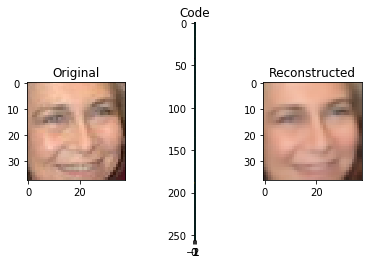

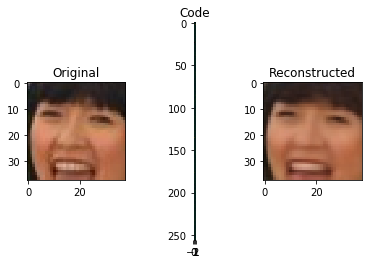

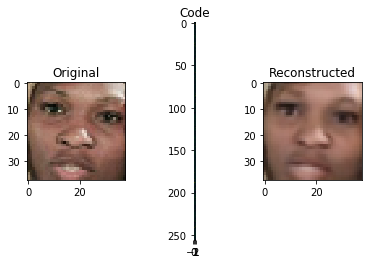

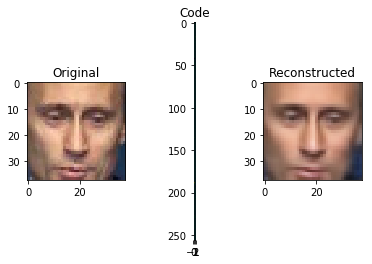

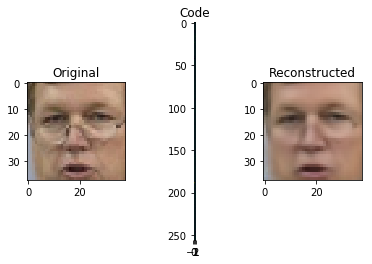

In [51]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [52]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Submit to Coursera

In [53]:
########## cheat grader ########################
reconstruction_mse = 0.0049

In [54]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(img_shape,code_size=71)
submit_autoencoder(submission, reconstruction_mse, 'wsdgh@qq.com', 'L8kLGdVgcfaNkRAC')

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [55]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [56]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

E:\Anaconda3\envs\tf1p2\lib\site-packages\sklearn\neighbors\approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [57]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [58]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

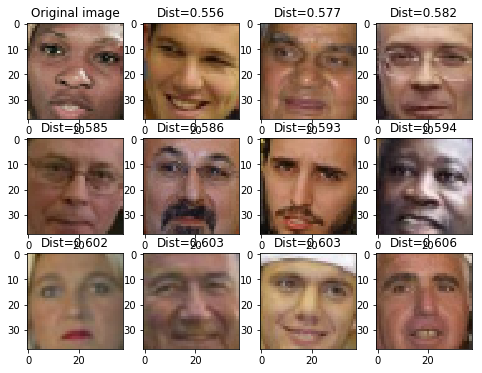

In [59]:
#smiles
show_similar(X_test[2])

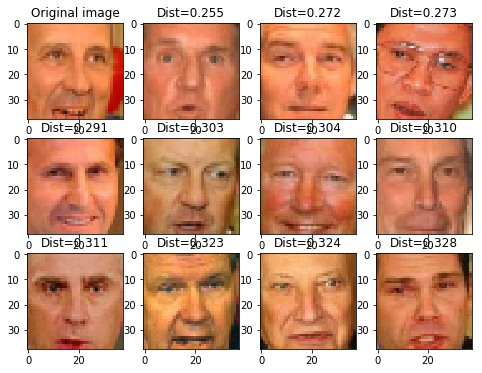

In [60]:
#ethnicity
show_similar(X_test[500])

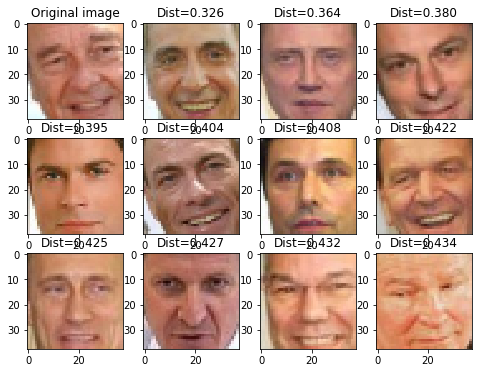

In [61]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


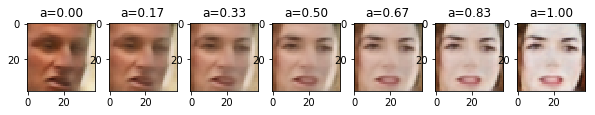

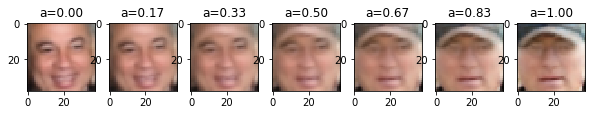

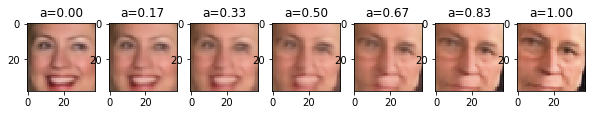

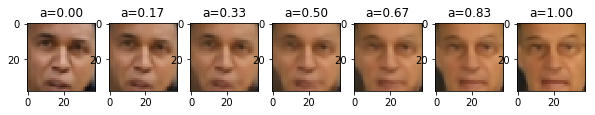

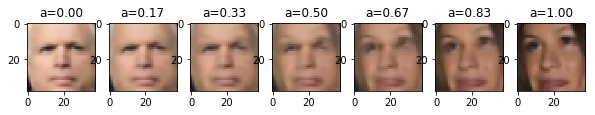

In [62]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))
    
    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.